In [20]:
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from keras.layers.convolutional import Conv2D
from keras.models import Model

In [21]:
from keras.layers import *
from keras.models import Model
from keras import optimizers


In [22]:
classes = 2

In [23]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/chest_xray/chest_xray/train'
valid_path = '/content/drive/MyDrive/chest_xray/chest_xray/test'

In [24]:
# ResNet building block of two layers
def building_block(X, filter_size, filters, stride=1):

    # Save the input value for shortcut
    X_shortcut = X

    # Reshape shortcut for later adding if dimensions change
    if stride > 1:

        X_shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(X_shortcut)
        X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # First layer of the block
    X = Conv2D(filters, kernel_size = filter_size, strides=stride, padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second layer of the block
    X = Conv2D(filters, kernel_size = filter_size, strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = add([X, X_shortcut])  # Add shortcut value to main path
    X = Activation('relu')(X)

    return X


In [25]:
input_shape=IMAGE_SIZE + [3]

In [26]:
# Full model
def create_model(input_shape, classes, name):

    # Define the input
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(filters=16, kernel_size=3, strides=(1, 1), padding='same')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Stage 2
    X = building_block(X, filter_size=3, filters=16, stride=1)
    X = building_block(X, filter_size=3, filters=16, stride=1)
    X = building_block(X, filter_size=3, filters=16, stride=1)
    X = building_block(X, filter_size=3, filters=16, stride=1)
    X = building_block(X, filter_size=3, filters=16, stride=1)

    # Stage 3
    X = building_block(X, filter_size=3, filters=32, stride=2)  # dimensions change (stride=2)
    X = building_block(X, filter_size=3, filters=32, stride=1)
    X = building_block(X, filter_size=3, filters=32, stride=1)
    X = building_block(X, filter_size=3, filters=32, stride=1)
    X = building_block(X, filter_size=3, filters=32, stride=1)

    # Stage 4
    X = building_block(X, filter_size=3, filters=64, stride=2)  # dimensions change (stride=2)
    X = building_block(X, filter_size=3, filters=64, stride=1)
    X = building_block(X, filter_size=3, filters=64, stride=1)
    X = building_block(X, filter_size=3, filters=64, stride=1)
    X = building_block(X, filter_size=3, filters=64, stride=1)

    # Average pooling and output layer
    X = GlobalAveragePooling2D()(X)
    X = Dense(classes, activation='softmax')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name=name)

    return model

In [27]:
# Define optimizer and compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ResNet32 = create_model(input_shape=input_shape, classes=classes, name='ResNet32')
ResNet32.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])

In [28]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [29]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/chest_xray/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [30]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/chest_xray/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [31]:
r = ResNet32.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
  
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
163/163 [==============================] - 213s 1s/step - loss: 0.2773 - accuracy: 0.8773 - val_loss: 5.4505 - val_accuracy: 0.6250
Epoch 2/5
163/163 [==============================] - 203s 1s/step - loss: 0.2209 - accuracy: 0.9101 - val_loss: 1.2885 - val_accuracy: 0.6490
Epoch 3/5
163/163 [==============================] - 204s 1s/step - loss: 0.1994 - accuracy: 0.9216 - val_loss: 0.4367 - val_accuracy: 0.8446
Epoch 4/5
163/163 [==============================] - 204s 1s/step - loss: 0.1719 - accuracy: 0.9337 - val_loss: 36.2353 - val_accuracy: 0.3782
Epoch 5/5
163/163 [==============================] - 204s 1s/step - loss: 0.1685 - accuracy: 0.9398 - val_loss: 1.3025 - val_accuracy: 0.5721


\

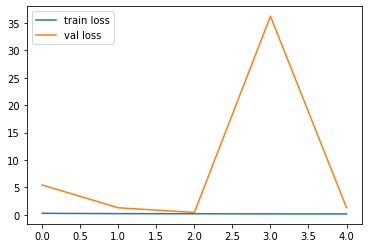

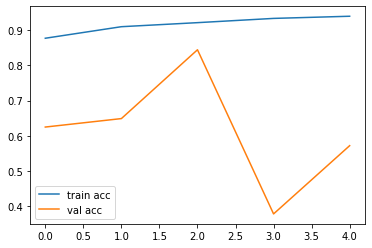

<Figure size 432x288 with 0 Axes>

In [32]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [34]:
ResNet32.save('model_ResNet32.h5')